In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
df=pd.read_table("prot_cap.csv")

In [4]:
df.head()

,frame.number,frame.time,frame.time_relative,ip.proto,ip.src,udp.srcport,tcp.srcport,ip.dst,udp.dstport,tcp.dstport,frame.len
0,1,"Apr 25, 2006 05:58:54.624365001 CDT",0.000000,17,192.168.62.121,32917,NaN,227.111.1.3,12345,NaN,1358
1,2,"Apr 25, 2006 05:58:54.624484002 CDT",0.000119,17,192.168.62.121,32915,NaN,227.111.1.1,12345,NaN,1358
2,3,"Apr 25, 2006 05:58:54.624692003 CDT",0.000327,17,192.168.62.121,32916,NaN,227.111.1.2,12345,NaN,1358
3,4,"Apr 25, 2006 05:58:54.624911004 CDT",0.000546,17,192.168.62.121,32920,NaN,227.111.1.4,12345,NaN,1358
4,5,"Apr 25, 2006 05:58:54.625132000 CDT",0.000767,17,192.168.62.121,32923,NaN,227.111.1.6,12345,NaN,1358


In [5]:
df["frame.number"].describe()

count    13519.000000
mean      6760.000000
std       3902.743479
min          1.000000
25%       3380.500000
50%       6760.000000
75%      10139.500000
max      13519.000000
Name: frame.number, dtype: float64

In [6]:
# Nanosecond and timezone support!! Nice!
df["frame.dt"] = df["frame.time"].apply(lambda x: pd.to_datetime(x, format="%b %d, %Y %H:%M:%S.%f %Z"))
#df["frame.dt"] = df["frame.time"].apply(lambda x:np.datetime64(x[:-4]))
df["frame.dt"].head()
df["frame.dt"].iloc[1]

Timestamp('2006-04-25 05:58:54.624484002')

In [7]:
dft = df.set_index("frame.dt")
dft.head()

,frame.number,frame.time,frame.time_relative,ip.proto,ip.src,udp.srcport,tcp.srcport,ip.dst,udp.dstport,tcp.dstport,frame.len
frame.dt,,,,,,,,,,,
2006-04-25 05:58:54.624365001,1,"Apr 25, 2006 05:58:54.624365001 CDT",0.000000,17,192.168.62.121,32917,NaN,227.111.1.3,12345,NaN,1358
2006-04-25 05:58:54.624484002,2,"Apr 25, 2006 05:58:54.624484002 CDT",0.000119,17,192.168.62.121,32915,NaN,227.111.1.1,12345,NaN,1358
2006-04-25 05:58:54.624692003,3,"Apr 25, 2006 05:58:54.624692003 CDT",0.000327,17,192.168.62.121,32916,NaN,227.111.1.2,12345,NaN,1358
2006-04-25 05:58:54.624911004,4,"Apr 25, 2006 05:58:54.624911004 CDT",0.000546,17,192.168.62.121,32920,NaN,227.111.1.4,12345,NaN,1358
2006-04-25 05:58:54.625132000,5,"Apr 25, 2006 05:58:54.625132000 CDT",0.000767,17,192.168.62.121,32923,NaN,227.111.1.6,12345,NaN,1358


In [44]:
# Find all conversations
# Potential example
# Addr_A, Port_A, Addr_B, Port_B, total_packets, total_bytes, bytes A=>B, bytes B=>A, Max_ms_per_sec_burst A=>B, Max_ms_per_sec_burst B=>A

# This shows all the unique values ie in this case for "ip.proto"
print (df["ip.proto"].unique())
print(type(dft["ip.src"][0]))

def get_conv_id(row, return_id):
    sip = row["ip.src"]
    try:
        is_udp = int(row["ip.proto"]) == 17
    except:
        return None
    if is_udp:
        sport = row ["udp.srcport"]
    else:
        sport = row["tcp.srcport"]
        
    tip= row["ip.dst"]
    if is_udp:
        tport = row ["udp.dstport"]
    else:
        tport = row["tcp.dstport"]
        
    direction="a->b"
    if tip==sip:
        if tport<sport:
            direction="b->a"
            tmp=sport
            sport=tport
            tport=tmp
    elif tip<sip:
        direction="b->a"
        tmp=sip
        sip=tip
        tip=tmp
        tmp=sport
        sport=tport
        tport=tmp

    else:
        pass
    conv_id = "{}:{}-{}:{}".format(sip,int(sport),tip,int(tport))
    if return_id:
        return conv_id
    else:
        return direction
    
dft["conv"] = dft.apply(lambda x:get_conv_id(x,True),axis=1)
dft["conv_dir"] = dft.apply(lambda x:get_conv_id(x,False),axis=1)


#print(df[["conv","conv_dir"]][:25])
grpd = dft.groupby("conv")
grpd2 = dft.groupby(["conv","conv_dir"])
framelen_per_convo = grpd["frame.len"].sum()
#started = grpd["frame.dt"].min()
#ended = grpd["frame.dt"].max()
#print(framelen_per_convo)
#print(len(framelen_per_convo))
#print(started)
#ended-started
bytes_per_dir = dft.groupby(["conv","conv_dir"])["frame.len"].sum()
bytes_per_dir.order(inplace=True, ascending=False)
#print(bytes_per_dir)
    

[ 17.   6.  nan]
<class 'str'>


/Users/qavila/.pyenv/versions/3.4.3/lib/python3.4/site-packages/IPython/kernel/__main__.py:65: FutureWarning: order is deprecated, use sort_values(...)


In [55]:
dft.head()

,frame.number,frame.time,frame.time_relative,ip.proto,ip.src,udp.srcport,tcp.srcport,ip.dst,udp.dstport,tcp.dstport,frame.len,conv,conv_dir
frame.dt,,,,,,,,,,,,,
2006-04-25 05:58:54.624365001,1,"Apr 25, 2006 05:58:54.624365001 CDT",0.000000,17,192.168.62.121,32917,NaN,227.111.1.3,12345,NaN,1358,192.168.62.121:32917-227.111.1.3:12345,a->b
2006-04-25 05:58:54.624484002,2,"Apr 25, 2006 05:58:54.624484002 CDT",0.000119,17,192.168.62.121,32915,NaN,227.111.1.1,12345,NaN,1358,192.168.62.121:32915-227.111.1.1:12345,a->b
2006-04-25 05:58:54.624692003,3,"Apr 25, 2006 05:58:54.624692003 CDT",0.000327,17,192.168.62.121,32916,NaN,227.111.1.2,12345,NaN,1358,192.168.62.121:32916-227.111.1.2:12345,a->b
2006-04-25 05:58:54.624911004,4,"Apr 25, 2006 05:58:54.624911004 CDT",0.000546,17,192.168.62.121,32920,NaN,227.111.1.4,12345,NaN,1358,192.168.62.121:32920-227.111.1.4:12345,a->b
2006-04-25 05:58:54.625132000,5,"Apr 25, 2006 05:58:54.625132000 CDT",0.000767,17,192.168.62.121,32923,NaN,227.111.1.6,12345,NaN,1358,192.168.62.121:32923-227.111.1.6:12345,a->b


In [56]:
#print(started)
#ended-started
dft["frame.dt"] =dft.index
grpd = dft.groupby(["conv"])
sumAB = grpd.apply(lambda x:x[x.conv_dir=="a->b"]["frame.len"].sum())
sumBA = grpd.apply(lambda x:x[x.conv_dir=="b->a"]["frame.len"].sum())
started = grpd["frame.dt"].min()
ended = grpd["frame.dt"].max()
duration = ended - started
print(sumAB)



conv
10.100.100.100:2834-192.168.62.121:5901       5360
10.100.100.100:4610-192.168.62.121:22          438
10.100.100.100:4615-192.168.62.121:22          106
192.168.62.121:32915-227.111.1.1:12345     3686970
192.168.62.121:32916-227.111.1.2:12345     1351210
192.168.62.121:32917-227.111.1.3:12345     3481912
192.168.62.121:32920-227.111.1.4:12345     2748592
192.168.62.121:32921-227.111.1.5:12345     3384136
192.168.62.121:32923-227.111.1.6:12345     3287718
192.168.62.121:32927-192.168.62.2:53          4063
192.168.62.188:137-192.168.62.255:137          276
192.168.62.249:137-192.168.62.255:137          368
192.168.62.255:11-192.168.62.98:11               0
192.168.62.95:6-236.0.0.0:6                   1275
dtype: int64


In [65]:
def frame_len_to_rate(x):
    return x * 8

def get_max_frame_rate(x,direction):
    
    rows = x[x.conv_dir==direction]
    if len(rows)==0:
        return 0.0
    
    else:
        return rows.resample("L",how="sum")["frame.len"].apply(frame_len_to_rate).max()

max_frame_rateAB = grpd.apply(lambda x: get_max_frame_rate(x,"a->b"))
max_frame_rateBA = grpd.apply(lambda x: get_max_frame_rate(x,"b->a"))

In [66]:
by_conv = pd.DataFrame(sumAB, columns=["A->B"])
by_conv["B->A"] = sumBA
by_conv["started"] = started
by_conv["duration"] = duration
by_conv["maxRateAB"] = max_frame_rateAB 
by_conv["maxRateBA"] = max_frame_rateBA
print(by_conv.head())

                                            A->B   B->A  \
conv                                                      
10.100.100.100:2834-192.168.62.121:5901     5360  29511   
10.100.100.100:4610-192.168.62.121:22        438   7428   
10.100.100.100:4615-192.168.62.121:22        106    722   
192.168.62.121:32915-227.111.1.1:12345   3686970      0   
192.168.62.121:32916-227.111.1.2:12345   1351210      0   

                                                              started  \
conv                                                                    
10.100.100.100:2834-192.168.62.121:5901 2006-04-25 05:58:54.627440000   
10.100.100.100:4610-192.168.62.121:22   2006-04-25 05:58:55.147473000   
10.100.100.100:4615-192.168.62.121:22   2006-04-25 05:58:56.346390000   
192.168.62.121:32915-227.111.1.1:12345  2006-04-25 05:58:54.624484002   
192.168.62.121:32916-227.111.1.2:12345  2006-04-25 05:58:54.624692003   

                                               duration  maxRateAB  maxRat

In [33]:
#grpd.groups.keys()
#test = grpd.get_group("192.168.62.249:137-192.168.62.255:137")
#print(test)
def frame_len_to_rate(x):
    return x * 8


max_frame_rate = grpd2.apply(lambda x: x.resample("L",how="sum")["frame.len"]
                            .apply(frame_len_to_rate).max())


max_frame_rate_time = grpd2.apply(lambda x: x.resample("L",how="sum")["frame.len"]
                            .apply(frame_len_to_rate).argmax())
#oined = pd.DataFramemax_frame_rate.join(max_frame_rate_time)
combined = pd.DataFrame(max_frame_rate.values, index=max_frame_rate.index,
                        columns=["max.frame.rate"])
combined["max.frame.rate.time"] = max_frame_rate_time
print(combined)


                                                  max.frame.rate  \
conv                                    conv_dir                   
10.100.100.100:2834-192.168.62.121:5901 a->b                 992   
                                        b->a               24224   
10.100.100.100:4610-192.168.62.121:22   a->b                1696   
                                        b->a               28848   
10.100.100.100:4615-192.168.62.121:22   a->b                 848   
                                        b->a                5296   
192.168.62.121:32915-227.111.1.1:12345  a->b               21728   
192.168.62.121:32916-227.111.1.2:12345  a->b               10864   
192.168.62.121:32917-227.111.1.3:12345  a->b               21728   
192.168.62.121:32920-227.111.1.4:12345  a->b               21728   
192.168.62.121:32921-227.111.1.5:12345  a->b               32592   
192.168.62.121:32923-227.111.1.6:12345  a->b               21728   
192.168.62.121:32927-192.168.62.2:53    a->b    

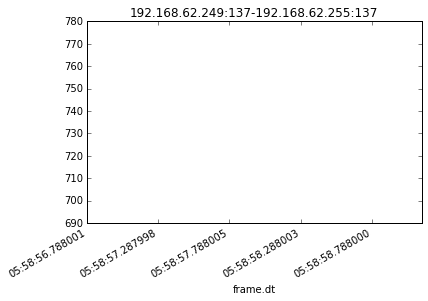

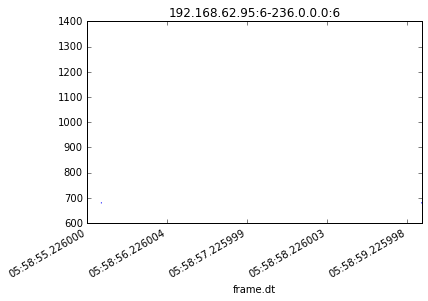

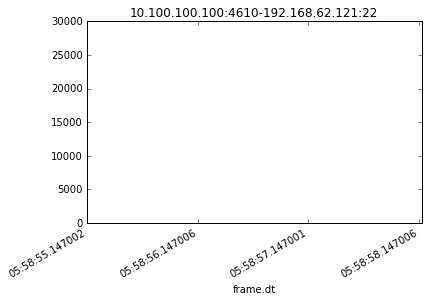

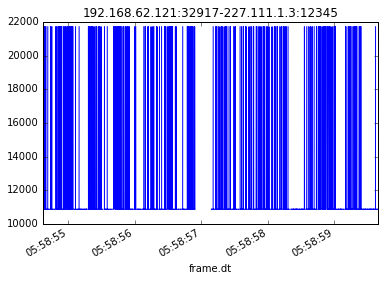

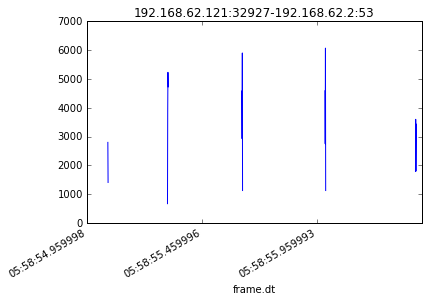

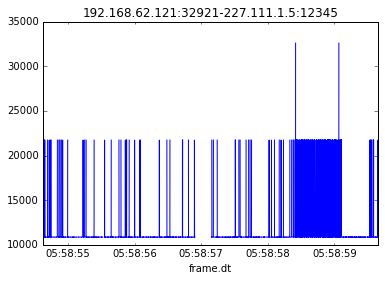

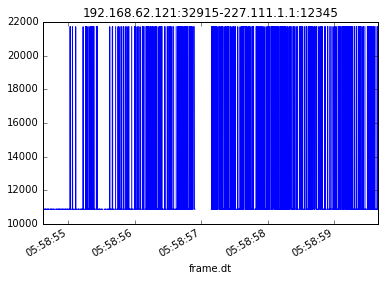

/Users/qavila/.pyenv/versions/3.4.3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=732426.249248, right=732426.249248
  'left=%s, right=%s') % (left, right))


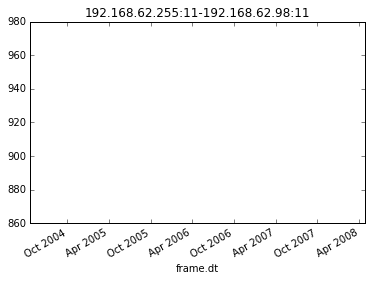

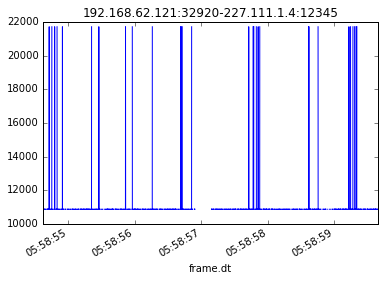

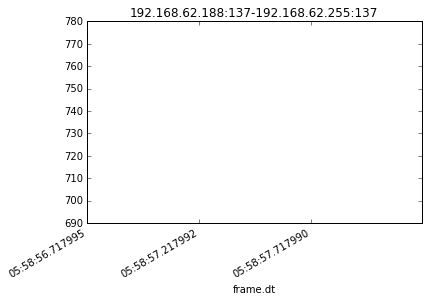

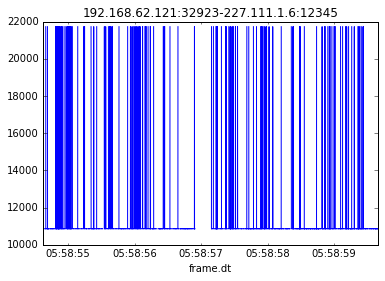

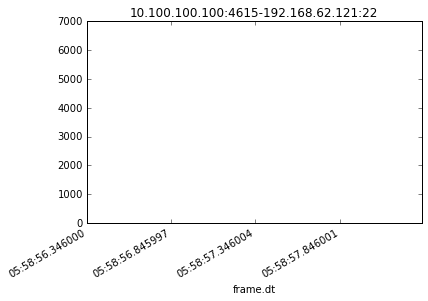

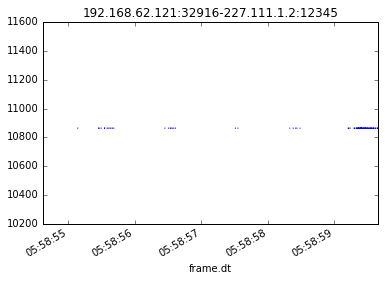

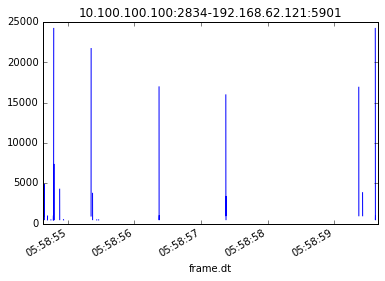

In [42]:
# plot the data for a specific conversation
#group_id = "192.168.62.121:32921-227.111.1.5:12345"

for group_id in grpd.groups.keys():
    curr_conv = grpd.get_group(group_id)
    #print(curr_conv)
    ts1 = curr_conv.resample("L",how="sum")["frame.len"].apply(frame_len_to_rate)
    ts1.plot(title=group_id)
    plt.show()
    plt.clf()



In [43]:
dft.head()

,frame.number,frame.time,frame.time_relative,ip.proto,ip.src,udp.srcport,tcp.srcport,ip.dst,udp.dstport,tcp.dstport,frame.len,conv,conv_dir
frame.dt,,,,,,,,,,,,,
2006-04-25 05:58:54.624365001,1,"Apr 25, 2006 05:58:54.624365001 CDT",0.000000,17,192.168.62.121,32917,NaN,227.111.1.3,12345,NaN,1358,192.168.62.121:32917-227.111.1.3:12345,a->b
2006-04-25 05:58:54.624484002,2,"Apr 25, 2006 05:58:54.624484002 CDT",0.000119,17,192.168.62.121,32915,NaN,227.111.1.1,12345,NaN,1358,192.168.62.121:32915-227.111.1.1:12345,a->b
2006-04-25 05:58:54.624692003,3,"Apr 25, 2006 05:58:54.624692003 CDT",0.000327,17,192.168.62.121,32916,NaN,227.111.1.2,12345,NaN,1358,192.168.62.121:32916-227.111.1.2:12345,a->b
2006-04-25 05:58:54.624911004,4,"Apr 25, 2006 05:58:54.624911004 CDT",0.000546,17,192.168.62.121,32920,NaN,227.111.1.4,12345,NaN,1358,192.168.62.121:32920-227.111.1.4:12345,a->b
2006-04-25 05:58:54.625132000,5,"Apr 25, 2006 05:58:54.625132000 CDT",0.000767,17,192.168.62.121,32923,NaN,227.111.1.6,12345,NaN,1358,192.168.62.121:32923-227.111.1.6:12345,a->b


In [65]:
grpd2 = df.groupby(["conv","conv_dir"])
#print (grpd2.apply(lambda df:1000*df["frame.len"].resample("L", how="sum") * 8.0 ))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex

In [43]:
#Filter on Conversation for bps and max ms burst

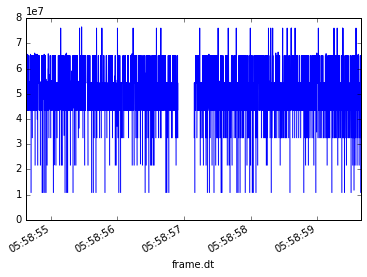

In [29]:
# Frequency resample flags"L" millisecond "U" microsecond
bits_per_second_per_ms =  1000*dft["frame.len"].resample("L", how="sum") * 8.0
# myslice = bits_per_second_per_ms[910:925]
bits_per_second_per_ms.plot()
# myslice.plot()

In [30]:
# Spikes
print(bits_per_second_per_ms.max())
spikes = bits_per_second_per_ms[bits_per_second_per_ms>70000000]
print(spikes)
#Need to review getting all conversations for burst intervals

76528000.0
frame.dt
2006-04-25 05:58:55.146    76048000
2006-04-25 05:58:55.430    76048000
2006-04-25 05:58:55.461    76528000
2006-04-25 05:58:55.685    76048000
2006-04-25 05:58:55.765    76048000
2006-04-25 05:58:55.766    76048000
2006-04-25 05:58:56.000    76048000
2006-04-25 05:58:56.235    76048000
2006-04-25 05:58:56.586    76048000
2006-04-25 05:58:56.652    76048000
2006-04-25 05:58:57.236    76048000
2006-04-25 05:58:57.513    76048000
2006-04-25 05:58:57.665    76048000
2006-04-25 05:58:57.786    76048000
2006-04-25 05:58:57.997    76048000
2006-04-25 05:58:58.270    76048000
2006-04-25 05:58:58.304    76048000
2006-04-25 05:58:58.331    76048000
2006-04-25 05:58:58.333    76048000
2006-04-25 05:58:58.483    76048000
2006-04-25 05:58:58.551    76048000
2006-04-25 05:58:58.611    76048000
2006-04-25 05:58:58.616    76048000
2006-04-25 05:58:58.670    76048000
2006-04-25 05:58:59.020    76048000
2006-04-25 05:58:59.255    76048000
2006-04-25 05:58:59.303    76048000
2006-04-

In [13]:
# Definable Directional lists. ie.

In [18]:
#Quick time test
#http://pandas.pydata.org/pandas-docs/stable/gotchas.html
begin = pd.Timestamp.min

In [19]:
begin

Timestamp('1677-09-22 00:12:43.145225')

In [20]:
end = pd.Timestamp.max

In [21]:
end

Timestamp('2262-04-11 23:47:16.854775807')